# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\lenovo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
print("Data Points in Each class :")
print(filtered_data['Score'].value_counts()) 
filtered_data.head(3)

Number of data points in our data (525814, 10)
Data Points in Each class :
positive    443777
negative     82037
Name: Score, dtype: int64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting the data taking productid as the parameter
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.shape

(525814, 10)

In [5]:
#Deleting the dublicates reviews which is created when user writed a review for the product, it automatically generates for the same product of different color etc
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
#Dropping the data which has HelpfulnessNumerator<HelpfulnessDenominator which is impossible
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
#Checking to see how much % of data still remains
print("Percentage of data still remains",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

print("Final Data",final.shape)

Percentage of data still remains 69.25852107399194
Final Data (364171, 10)


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
from tqdm import tqdm
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [09:46<00:00, 620.51it/s]


In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [3]:
final_data=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#For Linear SVM
final = final_data.head(100000)

In [7]:
#For Linear SVM
X_train_data = final[:60000]
X_test_data = final[60000:100000]
y_train = X_train_data['Score']
y_test = X_test_data['Score']
print("Data")
print(X_train_data.shape)
print(X_test_data.shape)
print("Label")
print(y_train.shape)
print(y_test.shape)

Data
(60000, 11)
(40000, 11)
Label
(60000,)
(40000,)


In [4]:
#for RBF kernel
#since it is taking very long long time to train so i have taken 20k data points
final1 = final_data.head(20000)

In [5]:
#for RBF kernel
X_train_data1 = final1[:14000]
X_test_data1 = final1[14000:20000]
y_train1 = X_train_data1['Score']
y_test1 = X_test_data1['Score']
print("Data")
print(X_train_data1.shape)
print(X_test_data1.shape)
print("Label")
print(y_train1.shape)
print(y_test1.shape) 
# since it take very long time for computation so i have take 30k points and from that i have taken 21k for training and 9k for testing

Data
(14000, 11)
(6000, 11)
Label
(14000,)
(6000,)


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
# For Linear Kernel

In [16]:
#BoW on Text
print("**Bow Vectorizer**")
print("="*50)
count_vect = CountVectorizer(min_df = 50)
X_train_BOW = count_vect.fit_transform(X_train_data['CleanedText'])
X_test_BOW = count_vect.transform(X_test_data['CleanedText'])
print(X_train_BOW.shape)
print(X_test_BOW.shape)

**Bow Vectorizer**
(60000, 2951)
(40000, 2951)


In [6]:
# For RBF Kernel

In [7]:
#BoW on Text
print("**Bow Vectorizer**")
print("="*50)
count_vect1 = CountVectorizer(min_df = 50,max_features=250) #since it is very costly for rbf kernel so reducing the dimention
X_train_BOW1 = count_vect1.fit_transform(X_train_data1['CleanedText'])
X_test_BOW1 = count_vect1.transform(X_test_data1['CleanedText'])
print(X_train_BOW1.shape)
print(X_test_BOW1.shape)

**Bow Vectorizer**
(14000, 250)
(6000, 250)


## [4.2] Bi-Grams and n-Grams.

## [4.3] TF-IDF

In [ ]:
# For Linear Kernel

In [17]:
#TFIDF on Text
print("**TFIDF Vectorizer**")
print("="*50)
tf_idf_vect = TfidfVectorizer(min_df = 50)
X_train_tfidf = tf_idf_vect.fit_transform(X_train_data['CleanedText'])
X_test_tfidf = tf_idf_vect.transform(X_test_data['CleanedText'])
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

**TFIDF Vectorizer**
(60000, 2951)
(40000, 2951)


In [8]:
# For RBF Kernel

In [6]:
#TFIDF on Text
print("**TFIDF Vectorizer**")
print("="*50)
tf_idf_vect1 = TfidfVectorizer(min_df = 50,max_features=250)#since it is very costly for rbf kernel so reducing the dimention
X_train_tfidf1 = tf_idf_vect1.fit_transform(X_train_data1['CleanedText'])
X_test_tfidf1 = tf_idf_vect1.transform(X_test_data1['CleanedText'])
print(X_train_tfidf1.shape)
print(X_test_tfidf1.shape)

**TFIDF Vectorizer**
(14000, 250)
(6000, 250)


## [4.4] Word2Vec

In [ ]:
# for Linear kernel

In [18]:
import gensim
i=0
list_of_sent_train=[]
for sent in tqdm(X_train_data['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:17<00:00, 3403.32it/s]


In [19]:
import gensim
i=0
list_of_sent_test=[]
for sent in tqdm(X_test_data['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:13<00:00, 3000.71it/s]


In [20]:
print(X_train_data['Text'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is'

In [21]:
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=6)

In [22]:
w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))

14907


In [23]:
w2v_model.wv.most_similar('good')

[('great', 0.8150734305381775),
 ('decent', 0.7626655697822571),
 ('fantastic', 0.7215977907180786),
 ('yummy', 0.7074267268180847),
 ('bad', 0.6985136270523071),
 ('fine', 0.6977730393409729),
 ('wonderful', 0.6919105052947998),
 ('tasty', 0.6868084669113159),
 ('terrific', 0.6795011162757874),
 ('awesome', 0.6652669906616211)]

In [24]:
w2v_model.wv.most_similar('tasty')

[('satisfying', 0.8221983313560486),
 ('filling', 0.813472330570221),
 ('yummy', 0.8058117628097534),
 ('delicious', 0.8046582937240601),
 ('tastey', 0.7333153486251831),
 ('flavorful', 0.7171689867973328),
 ('nutritious', 0.6994925141334534),
 ('hearty', 0.6935489177703857),
 ('healthy', 0.6896628141403198),
 ('versatile', 0.6870435476303101)]

In [27]:
w2v_model.wv.most_similar('horrible')

[('terrible', 0.9271645545959473),
 ('awful', 0.8844239115715027),
 ('funny', 0.8325157761573792),
 ('weird', 0.8166970014572144),
 ('disgusting', 0.8017832040786743),
 ('nasty', 0.7596052885055542),
 ('gross', 0.7593578100204468),
 ('strange', 0.7512959837913513),
 ('ok', 0.713072657585144),
 ('bad', 0.6877822279930115)]

In [7]:
# for RBF kernel

In [8]:
import gensim
i=0
list_of_sent_train1=[]
for sent in tqdm(X_train_data1['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_train1.append(filtered_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 14000/14000 [00:03<00:00, 3539.92it/s]


In [9]:
import gensim
i=0
list_of_sent_test1=[]
for sent in tqdm(X_test_data1['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_test1.append(filtered_sentence)

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:01<00:00, 4015.34it/s]


In [10]:
print(X_train_data1['Text'].values[0])
print("*****************************************************************")
print(list_of_sent_train1[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is'

In [11]:
w2v_model1=gensim.models.Word2Vec(list_of_sent_train1,min_count=5,size=50, workers=6)

In [12]:
w2v_words1 = list(w2v_model1.wv.vocab)
print(len(w2v_words1))

7614


In [13]:
w2v_model1.wv.most_similar('good')

[('great', 0.7697887420654297),
 ('fine', 0.762452244758606),
 ('bad', 0.728742241859436),
 ('yummy', 0.6936498880386353),
 ('fantastic', 0.6931329369544983),
 ('amazing', 0.6921795606613159),
 ('delicious', 0.6793953776359558),
 ('wonderful', 0.6729916334152222),
 ('tasty', 0.6618772745132446),
 ('awesome', 0.6502667665481567)]

In [14]:
w2v_model1.wv.most_similar('tasty')

[('satisfying', 0.8953467607498169),
 ('yummy', 0.8878394365310669),
 ('filling', 0.8840778470039368),
 ('delicious', 0.8232280015945435),
 ('crunchy', 0.816642701625824),
 ('moist', 0.8067997694015503),
 ('nutritious', 0.8029323816299438),
 ('light', 0.7990099191665649),
 ('chewy', 0.7983318567276001),
 ('crisp', 0.7792033553123474)]

In [15]:
w2v_model1.wv.most_similar('horrible')

[('awful', 0.9164963364601135),
 ('terrible', 0.8859406113624573),
 ('disgusting', 0.8709102869033813),
 ('gross', 0.8381292819976807),
 ('ok', 0.8229803442955017),
 ('disapointed', 0.8087189197540283),
 ('weird', 0.8058222532272339),
 ('rubbery', 0.8024954795837402),
 ('okay', 0.7930898666381836),
 ('horrid', 0.7824522256851196)]

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [17]:
# for Linear kernel

In [28]:
#TRAIN
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; 
for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec) 
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [03:20<00:00, 298.67it/s]


60000
50


In [29]:
#TEST
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; 
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec) 
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [02:17<00:00, 291.20it/s]


40000
50


In [16]:
# for RBF kernel

In [17]:
#TRAIN
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train1 = []; 
for sent in tqdm(list_of_sent_train1):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train1.append(sent_vec) 
print(len(sent_vectors_train1))
print(len(sent_vectors_train1[0]))

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:38<00:00, 365.97it/s]


14000
50


In [18]:
#TEST
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test1 = []; 
for sent in tqdm(list_of_sent_test1):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test1.append(sent_vec) 
print(len(sent_vectors_test1))
print(len(sent_vectors_test1[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:17<00:00, 347.82it/s]


6000
50


#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
#for Linear kernel

In [30]:
tfidf_vect = TfidfVectorizer(min_df = 50)
train_tfidf_w2v = tfidf_vect.fit_transform(X_train_data["CleanedText"])
test_tfidf_w2v = tfidf_vect.transform(X_test_data["CleanedText"])
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))
print(train_tfidf_w2v.shape)
print(test_tfidf_w2v.shape)

(60000, 2951)
(40000, 2951)


In [31]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [07:26<00:00, 134.52it/s]


In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [05:19<00:00, 125.18it/s]


In [25]:
#for RBF kernel

In [26]:
tfidf_vect1 = TfidfVectorizer(min_df = 10,max_features=500)
train_tfidf_w2v1 = tfidf_vect1.fit_transform(X_train_data1["CleanedText"])
test_tfidf_w2v1 = tfidf_vect1.transform(X_test_data1["CleanedText"])
dictionary = dict(zip(tfidf_vect1.get_feature_names(), list(tfidf_vect1.idf_)))
print(train_tfidf_w2v1.shape)
print(test_tfidf_w2v1.shape)

(14000, 500)
(6000, 500)


In [27]:
# TF-IDF weighted Word2Vec
tfidf_feat1 = tfidf_vect1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1 and word in tfidf_feat1:
            vec = w2v_model1.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train1.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:46<00:00, 302.61it/s]


In [28]:
# TF-IDF weighted Word2Vec
tfidf_feat1 = tfidf_vect1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1 and word in tfidf_feat1:
            vec = w2v_model1.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test1.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:18<00:00, 322.67it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [7]:
from sklearn import linear_model
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [153]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(X_train_BOW)
X_test = sc.transform(X_test_BOW)

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [154]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4] #alpha range between 10^-4 to 10^4
auc_score=[] # storing the auc value for each alpha


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    model.fit(X_train, y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.84s/it]



The optimal value of alpha is 0.010.


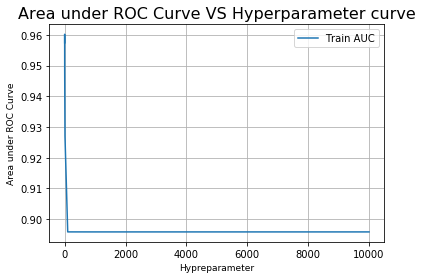

In [155]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()


***Test Data Report***
Best alpha =  0.01
AUC =  91.86692655900659


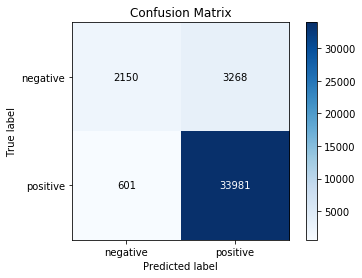

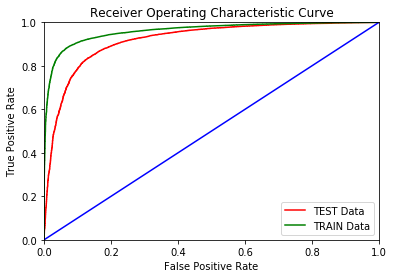

In [156]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Positive Features

In [157]:
#Top 20 positive features
feature_name = count_vect.get_feature_names()
w = model.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
great	-->	0.723412
love	-->	0.543646
best	-->	0.500579
perfect	-->	0.456267
delici	-->	0.418959
nice	-->	0.376998
good	-->	0.368626
excel	-->	0.364510
amaz	-->	0.315307
wonder	-->	0.272308
happi	-->	0.241294
favorit	-->	0.241027
smooth	-->	0.240786
addict	-->	0.239962
use	-->	0.236288
often	-->	0.234133
alway	-->	0.227288
beauti	-->	0.221237
skeptic	-->	0.216643


## Negative Features

In [158]:
#Top 20 negative features
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = tf_idf_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
disappoint	 -->	-0.343866  
worst	 -->	-0.318661  
terribl	 -->	-0.253012  
unfortun	 -->	-0.246452  
bland	 -->	-0.244275  
hope	 -->	-0.239821  
aw	 -->	-0.228602  
tast	 -->	-0.222850  
product	 -->	-0.222029  
guess	 -->	-0.213013  
bad	 -->	-0.205921  
stool	 -->	-0.204517  
money	 -->	-0.204111  
would	 -->	-0.181823  
yuck	 -->	-0.181754  
return	 -->	-0.174834  
hemp	 -->	-0.172570  
stick	 -->	-0.171421  
lack	 -->	-0.170732  
liver	 -->	-0.166372  


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [159]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(X_train_tfidf)
X_test = sc.transform(X_test_tfidf)

In [160]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4] #alpha range between 10^-4 to 10^4
auc_score=[] # storing the auc value for each alpha


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.19s/it]



The optimal value of alpha is 0.010.


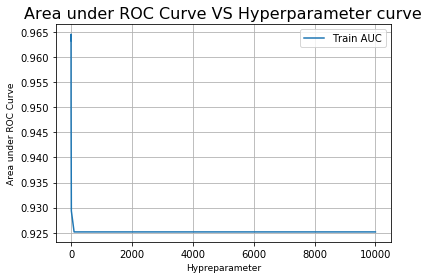

In [161]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.01
AUC =  92.37793426568538


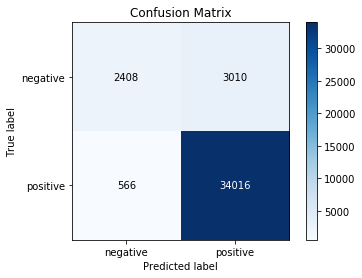

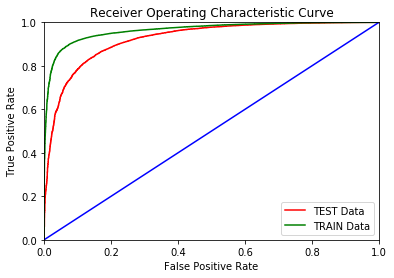

In [162]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Positive Features

In [163]:
feature_name = tfidf_vect.get_feature_names()
w = model.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
great	-->	0.832350
best	-->	0.651426
love	-->	0.625134
perfect	-->	0.483424
delici	-->	0.466447
excel	-->	0.454997
good	-->	0.336127
nice	-->	0.333911
wonder	-->	0.312056
favorit	-->	0.303064
amaz	-->	0.300530
addict	-->	0.270039
awesom	-->	0.269974
find	-->	0.264306
keep	-->	0.250032
smooth	-->	0.240012
tasti	-->	0.221423
uniqu	-->	0.219737
quick	-->	0.218052


## Negative Features

In [164]:
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = tf_idf_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
disappoint	 -->	-0.408480  
worst	 -->	-0.317245  
tast	 -->	-0.246682  
money	 -->	-0.235569  
bland	 -->	-0.222159  
product	 -->	-0.206248  
much	 -->	-0.198078  
weak	 -->	-0.197467  
terribl	 -->	-0.197040  
guess	 -->	-0.192669  
stale	 -->	-0.190279  
return	 -->	-0.188191  
aw	 -->	-0.182346  
stick	 -->	-0.181542  
dri	 -->	-0.175381  
item	 -->	-0.174154  
look	 -->	-0.171465  
lack	 -->	-0.167007  
tasteless	 -->	-0.166215  
hope	 -->	-0.165243  


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [165]:
#Standardising the train and test data
sc = StandardScaler()
X_train = sc.fit_transform(sent_vectors_train)
X_test = sc.transform(sent_vectors_test)

In [166]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4] #alpha range between 10^-4 to 10^4
auc_score=[] # storing the auc value for each alpha


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.26s/it]



The optimal value of alpha is 0.001.


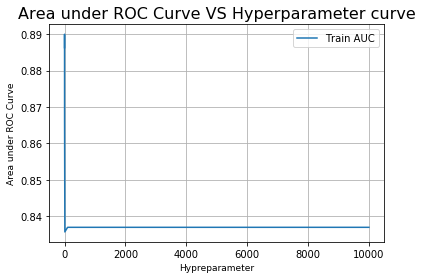

In [167]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.001
AUC =  88.94346623757541


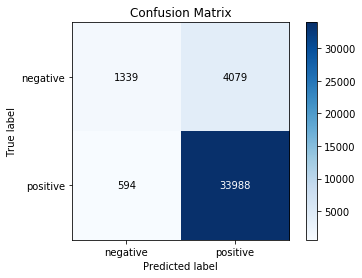

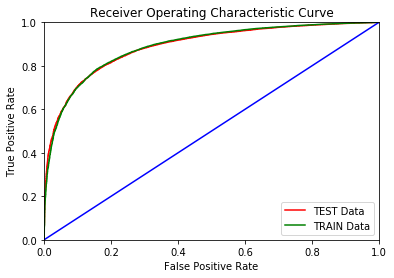

In [168]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [169]:
#Standardising the train and test data
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(tfidf_sent_vectors_train)
X_test = sc.transform(tfidf_sent_vectors_test)

In [170]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4] #alpha range between 10^-4 to 10^4
auc_score=[] # storing the auc value for each alpha


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.16s/it]



The optimal value of alpha is 0.001.


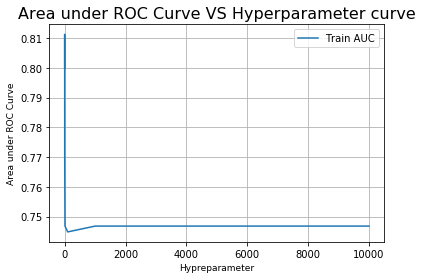

In [171]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.001
AUC =  81.17488429392861


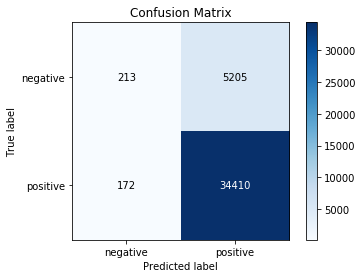

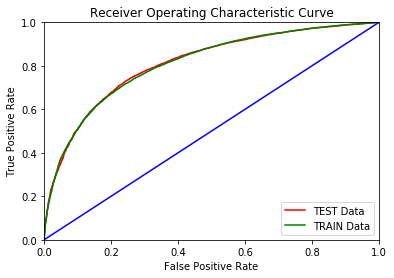

In [172]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive") #test data
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive") #train data

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

#### [NOTE] since GridSearch CV taking long long time to to find the best hyperparametr so i have written for loops over series of hyperparameter for finding the optimal of it

In [9]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(X_train_BOW1)
X_test = sc.transform(X_test_BOW1)

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
all_C = [2**-1, 2**1, 2**3, 2**5, 2**7, 2**9]
all_Gammas = [2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5]
#param_grid = {'C': all_C, 'gamma' : all_Gammas}
auc_scores = []
# range of C and Gamas
# https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters


for i in tqdm(range(0,len(all_C))):
    model = svm.SVC(C = all_C[i], gamma=all_Gammas[i], kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
    model.fit(X_train,y_train1)
    pred = model.predict(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test1, model.predict_proba(X_test)[:,1],pos_label="positive")
    auc = metrics.auc(fpr, tpr)
    auc_scores.append(auc*100)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:21:25<00:00, 855.93s/it]



The optimal value of C is 0.500.

The optimal value of Gamma is 0.031.


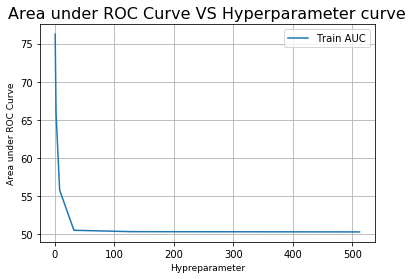

In [13]:
# determining best value of C
optimal_C = all_C[auc_scores.index(max(auc_scores))]
optimal_Gamma = all_Gammas[auc_scores.index(max(auc_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
print('\nThe optimal value of Gamma is %.3f.' % optimal_Gamma)

# plot AUC vs C
plt.plot(all_C, auc_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

In [10]:
optimal_C = 0.500
optimal_Gamma = 0.031

***Test Data Report***
AUC =  76.25102961081073


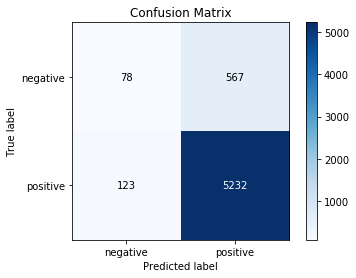

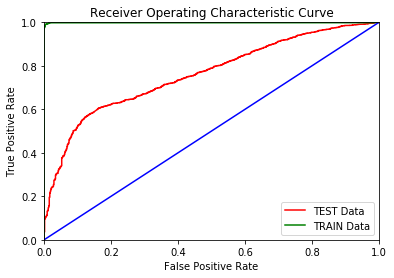

In [11]:
lr = svm.SVC(C = optimal_C, gamma=optimal_Gamma, kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
lr.fit(X_train,y_train1)
pred = lr.predict(X_test)



print("***Test Data Report***")
fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test1, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive") #test data
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train1, lr.predict_proba(X_train)[:,1],pos_label="positive") #train data

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

#### [NOTE] since GridSearch CV taking long long time to to find the best hyperparametr so i have written for loops over series of hyperparameter for finding the optimal of it

In [8]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(X_train_tfidf1)
X_test = sc.transform(X_test_tfidf1)

In [9]:
all_C = [2**-1, 2**1, 2**3, 2**5, 2**7, 2**9]
all_Gammas = [2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5]
#param_grid = {'C': all_C, 'gamma' : all_Gammas}
auc_scores = []
# range of C and Gamas
# https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters


for i in tqdm(range(0,len(all_C))):
    model = svm.SVC(C = all_C[i], gamma=all_Gammas[i], kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
    model.fit(X_train,y_train1)
    pred = model.predict(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test1, model.predict_proba(X_test)[:,1],pos_label="positive")
    auc = metrics.auc(fpr, tpr)
    auc_scores.append(auc*100)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:26:05<00:00, 880.37s/it]



The optimal value of C is 0.500.

The optimal value of Gamma is 0.031.


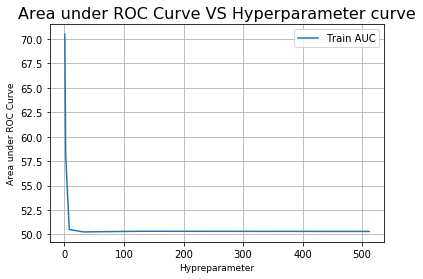

In [10]:
# determining best value of C
optimal_C = all_C[auc_scores.index(max(auc_scores))]
optimal_Gamma = all_Gammas[auc_scores.index(max(auc_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
print('\nThe optimal value of Gamma is %.3f.' % optimal_Gamma)

# plot AUC vs C
plt.plot(all_C, auc_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
AUC =  70.4728320268676


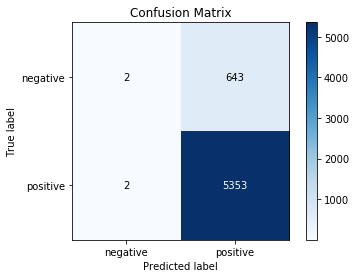

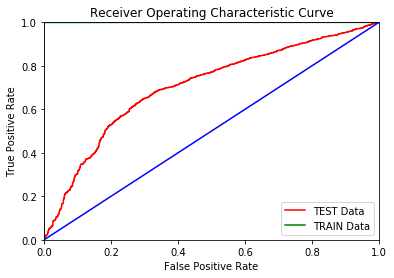

In [13]:
lr = svm.SVC(C = optimal_C, gamma=optimal_Gamma, kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
lr.fit(X_train,y_train1)
pred = lr.predict(X_test)



print("***Test Data Report***")
fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test1, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive") #test data
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train1, lr.predict_proba(X_train)[:,1],pos_label="positive") #train data

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

#### [NOTE] since GridSearch CV taking long long time to to find the best hyperparametr so i have written for loops over series of hyperparameter for finding the optimal of it

In [19]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(sent_vectors_train1)
X_test = sc.transform(sent_vectors_test1)

In [20]:
all_C = [2**-1, 2**1, 2**3, 2**5, 2**7, 2**9]
all_Gammas = [2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5]
#param_grid = {'C': all_C, 'gamma' : all_Gammas}
auc_scores = []
# range of C and Gamas
# https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters


for i in tqdm(range(0,len(all_C))):
    model = svm.SVC(C = all_C[i], gamma=all_Gammas[i], kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
    model.fit(X_train,y_train1)
    pred = model.predict(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test1, model.predict_proba(X_test)[:,1],pos_label="positive")
    auc = metrics.auc(fpr, tpr)
    auc_scores.append(auc*100)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [46:12<00:00, 528.63s/it]



The optimal value of C is 0.500.

The optimal value of Gamma is 0.031.


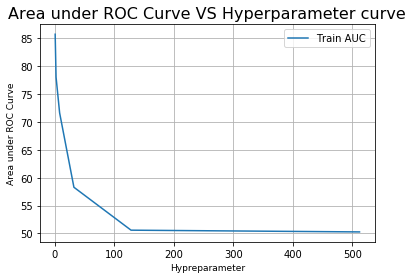

In [21]:
# determining best value of C
optimal_C = all_C[auc_scores.index(max(auc_scores))]
optimal_Gamma = all_Gammas[auc_scores.index(max(auc_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
print('\nThe optimal value of Gamma is %.3f.' % optimal_Gamma)

# plot AUC vs C
plt.plot(all_C, auc_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
AUC =  85.74087826345009


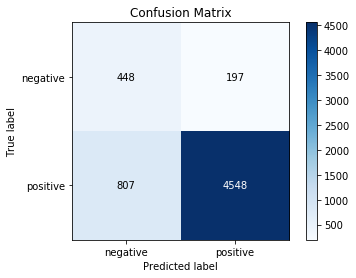

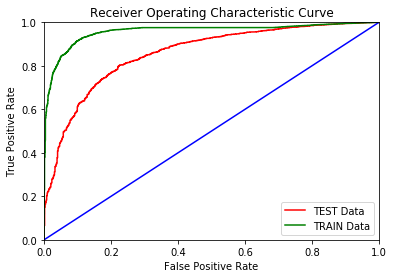

In [22]:
lr = svm.SVC(C = optimal_C, gamma=optimal_Gamma, kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
lr.fit(X_train,y_train1)
pred = lr.predict(X_test)



print("***Test Data Report***")
fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test1, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive") #test data
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train1, lr.predict_proba(X_train)[:,1],pos_label="positive") #train data

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

#### [NOTE] since GridSearch CV taking long long time to to find the best hyperparametr so i have written for loops over series of hyperparameter for finding the optimal of it

In [29]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(tfidf_sent_vectors_train1)
X_test = sc.transform(tfidf_sent_vectors_test1)

In [30]:
all_C = [2**-1, 2**1, 2**3, 2**5, 2**7, 2**9]
all_Gammas = [2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5]
#param_grid = {'C': all_C, 'gamma' : all_Gammas}
auc_scores = []
# range of C and Gamas
# https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters

for i in tqdm(range(0,len(all_C))):
    model = svm.SVC(C = all_C[i], gamma=all_Gammas[i], kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
    model.fit(X_train,y_train1)
    pred = model.predict(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test1, model.predict_proba(X_test)[:,1],pos_label="positive")
    auc = metrics.auc(fpr, tpr)
    auc_scores.append(auc*100)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [49:55<00:00, 581.57s/it]



The optimal value of C is 0.500.

The optimal value of Gamma is 0.031.


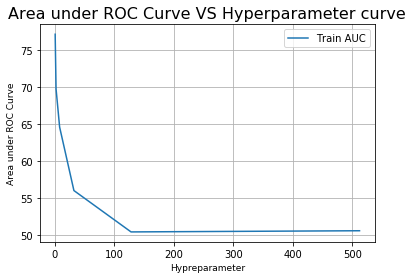

In [31]:
# determining best value of C
optimal_C = all_C[auc_scores.index(max(auc_scores))]
optimal_Gamma = all_Gammas[auc_scores.index(max(auc_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
print('\nThe optimal value of Gamma is %.3f.' % optimal_Gamma)

# plot AUC vs C
plt.plot(all_C, auc_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
AUC =  77.10552334628943


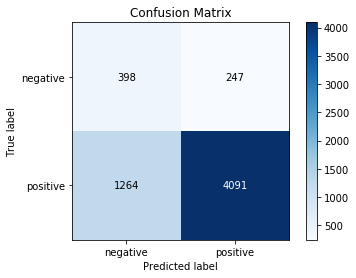

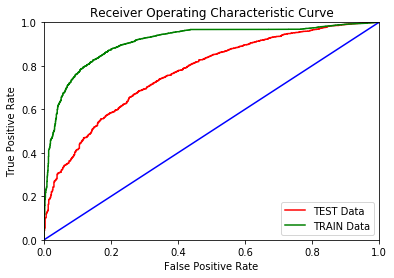

In [32]:
lr = svm.SVC(C = optimal_C, gamma=optimal_Gamma, kernel='rbf', probability=True, class_weight='balanced')#probability=True for computing the ROC score
lr.fit(X_train,y_train1)
pred = lr.predict(X_test)



print("***Test Data Report***")
fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test1, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test1, lr.predict_proba(X_test)[:,1],pos_label="positive") #test data
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train1, lr.predict_proba(X_train)[:,1],pos_label="positive") #train data

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# [6] Conclusions

In [14]:
#importing library
from prettytable import PrettyTable
x = PrettyTable()

#adding Field names
x.field_names = ["SL No.","Vectorizer","Kernel","Best (C)" ,"AUC"]

# adding row to table
x.add_row(["1","BOW","Linear",0.01,91.8669])
x.add_row(["2","BOW","RBF",0.5,76.2510])
x.add_row(["3","TFIDF","Linear",0.01,92.3779])
x.add_row(["4","TFIDF","RBF",0.5,70.4728])
x.add_row(["5","Avg-W2vec","Linear",0.001,88.9434])
x.add_row(["6","Avg-W2vec","RBF",0.5,85.7409])
x.add_row(["7","TFIDF-W2vec","Linear",0.001,81.1748])
x.add_row(["8","TFIDF-W2vec","RBF",0.5,77.1055])

#printing the table
print(x)

+--------+-------------+--------+----------+---------+
| SL No. |  Vectorizer | Kernel | Best (C) |   AUC   |
+--------+-------------+--------+----------+---------+
|   1    |     BOW     | Linear |   0.01   | 91.8669 |
|   2    |     BOW     |  RBF   |   0.5    |  76.251 |
|   3    |    TFIDF    | Linear |   0.01   | 92.3779 |
|   4    |    TFIDF    |  RBF   |   0.5    | 70.4728 |
|   5    |  Avg-W2vec  | Linear |  0.001   | 88.9434 |
|   6    |  Avg-W2vec  |  RBF   |   0.5    | 85.7409 |
|   7    | TFIDF-W2vec | Linear |  0.001   | 81.1748 |
|   8    | TFIDF-W2vec |  RBF   |   0.5    | 77.1055 |
+--------+-------------+--------+----------+---------+
